# CNN Model Inference - NSL-KDD

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## 1. Model Definition

In [2]:
class CNNClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=2, dropout_rate=0.3):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(8)
        self.fc1 = nn.Linear(256 * 8, 256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        return self.fc3(x)

## 2. Load Model and Scaler

In [3]:
checkpoint = torch.load('../../results/models/cnn_nsl_kdd.pt', map_location=device)
model = CNNClassifier(input_dim=checkpoint['input_dim'], num_classes=2)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

with open('../../results/models/cnn_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

print(f"✅ Model loaded! Expected features: {checkpoint['input_dim']}")

C:\Users\musab\AppData\Local\Temp\ipykernel_60224\1348865472.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../../results/models/cnn_nsl_kdd.pt

✅ Model loaded! Expected features: 122


## 3. Load Data and Build Feature Columns

In [4]:
COLUMNS = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

# Load BOTH train and test to get all categories
train_df = pd.read_csv('../../data/raw/nsl-kdd/train.txt', header=None, names=COLUMNS)
test_df = pd.read_csv('../../data/raw/nsl-kdd/test.txt', header=None, names=COLUMNS)
test_df['binary_label'] = test_df['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Combine to get ALL categories
combined = pd.concat([train_df, test_df], ignore_index=True)
categorical_cols = ['protocol_type', 'service', 'flag']
combined_encoded = pd.get_dummies(combined, columns=categorical_cols)
drop_cols = ['label', 'difficulty_level', 'binary_label']
FEATURE_COLS = sorted([c for c in combined_encoded.columns if c not in drop_cols])

print(f"Test samples: {len(test_df):,}")
print(f"Feature columns: {len(FEATURE_COLS)}")

Test samples: 22,544
Feature columns: 122


## 4. Predict Function

In [5]:
def predict(model, df, scaler, feature_cols, device):
    categorical_cols = ['protocol_type', 'service', 'flag']
    encoded = pd.get_dummies(df, columns=categorical_cols)
    
    # Add ALL missing columns with zeros
    for col in feature_cols:
        if col not in encoded.columns:
            encoded[col] = 0
    
    X = encoded[feature_cols].values
    X = scaler.transform(X)
    X_tensor = torch.FloatTensor(X).unsqueeze(1).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
    
    return preds.cpu().numpy(), probs[:, 1].cpu().numpy()

print("✅ Ready!")

✅ Ready!


## 5. Test Samples

In [6]:
sample_df = test_df.head(10)
predictions, probabilities = predict(model, sample_df, scaler, FEATURE_COLS, device)

print("="*70)
print("PREDICTIONS")
print("="*70)
for i, (pred, prob, actual, label) in enumerate(zip(
    predictions, probabilities, sample_df['binary_label'], sample_df['label']
)):
    pred_label = 'Attack' if pred == 1 else 'Normal'
    actual_label = 'Attack' if actual == 1 else 'Normal'
    match = '✅' if pred == actual else '❌'
    print(f"{i+1:2d}. Pred: {pred_label:6s} ({prob:5.1%}) | True: {actual_label:6s} ({label:15s}) {match}")

PREDICTIONS
 1. Pred: Attack (100.0%) | True: Attack (neptune        ) ✅
 2. Pred: Attack (100.0%) | True: Attack (neptune        ) ✅
 3. Pred: Normal ( 0.0%) | True: Normal (normal         ) ✅
 4. Pred: Attack (100.0%) | True: Attack (saint          ) ✅
 5. Pred: Normal ( 0.0%) | True: Attack (mscan          ) ❌
 6. Pred: Normal ( 0.0%) | True: Normal (normal         ) ✅
 7. Pred: Normal (17.2%) | True: Normal (normal         ) ✅
 8. Pred: Normal (19.1%) | True: Attack (guess_passwd   ) ❌
 9. Pred: Normal ( 0.0%) | True: Normal (normal         ) ✅
10. Pred: Normal ( 0.0%) | True: Attack (guess_passwd   ) ❌


## 6. Full Evaluation

Accuracy: 0.7757

              precision    recall  f1-score   support

      Normal       0.66      0.97      0.79      9711
      Attack       0.97      0.63      0.76     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.80      0.77     22544
weighted avg       0.84      0.78      0.77     22544



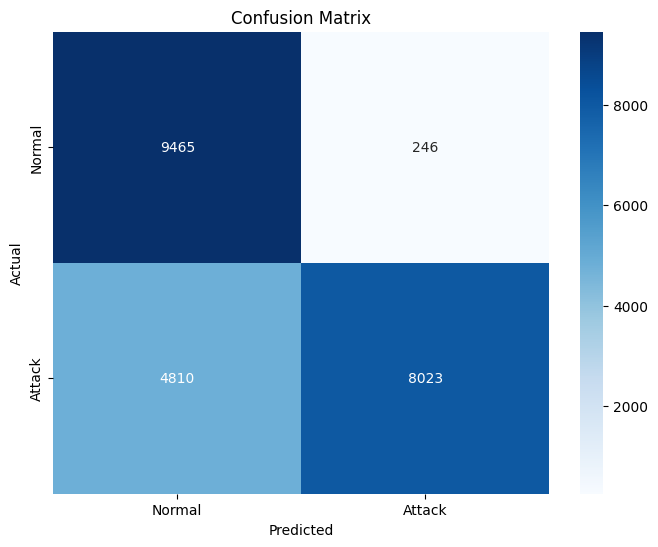

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds, _ = predict(model, test_df, scaler, FEATURE_COLS, device)
y_true = test_df['binary_label'].values

print(f"Accuracy: {accuracy_score(y_true, all_preds):.4f}\n")
print(classification_report(y_true, all_preds, target_names=['Normal', 'Attack']))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, all_preds), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()